In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
text = 'you say goodbye and I say hello.'
text = text.lower()
text = text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [3]:
words = text.split(' ') # 단어 단위로 분할
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [4]:
# 단어 ID와 단어 사전 생성

words_to_id = {}
id_to_words = {}

for word in words:
    if word not in words_to_id:
        new_id = len(words_to_id) # 새로운 단어 추가, ID는 현재의 단어 수
        words_to_id[word] = new_id
        id_to_words[new_id] = word
        
words_to_id
# id_to_words

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [5]:
words_to_id['hello']

5

In [6]:
corpus = [words_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [7]:
# 말뭉치 전처리 함수
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [8]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [9]:
print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 동시발생 행렬, 분포 가설에 기초해 단어를 벡터로 구현  

In [10]:
# 동시발생 행렬

c = np.array([[0, 1, 0, 0, 0, 0, 0],
              [1, 0, 1, 0, 1, 1, 0],
              [0, 1, 0, 1, 0, 0, 0],
              [0, 0, 1, 0, 1, 0, 0],
              [0, 1, 0, 1, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 1, 0]], dtype=np.int32)

In [11]:
print(c[0]) # ID가 0인 단어의 벡터 표현
print(c[word_to_id['goodbye']]) # goodbye의 벡터 표현


[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]


In [12]:
# 윈도우 크기가 1인 경우의 동시발생 행렬 생성 함수

def create_co_matrix(corpus, vocab_size, window_size=1): # corpus: 단어 ID 리스트, vocab_size: 어휘 수, window_size: 윈도우 크기 (기본값 1)
  
  corpus_size = len(corpus) # 말뭉치 크기
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32) # 동시발생 행렬 0으로 초기화
    
  for idx, word_id in enumerate(corpus): # idx는 인덱스이고, word_id는 단어 ID이다. idx는 순서 번호를 나타낸다. word_id는 단어 ID를 나타낸다.
    for i in range(1, window_size + 1): # 윈도우 크기가 1인 경우, 좌우 한 단어씩만 살펴본다.
      left_idx = idx - i                # 타깃 단어의 왼쪽에 있는 단어의 인덱스
      right_idx = idx + i               # 타깃 단어의 오른쪽에 있는 단어의 인덱스
            
      if left_idx >= 0:
        left_word_id = corpus[left_idx]
        co_matrix[word_id, left_word_id] += 1  # word_id: 행, left_word_id: 열
                
      if right_idx < corpus_size:
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1
                
  return co_matrix

In [13]:
# 예시 코드

# 먼저 말뭉치 전처리
text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(word_to_id)
print(id_to_word)

# 동시발생 행렬 생성
vocab_size = len(id_to_word) # word_to_id를 넣어도 됨
C = create_co_matrix(corpus, vocab_size)
print(C)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


In [40]:
len(word_to_id)

7

In [41]:
for idx, word_id in enumerate(corpus):
  print(idx, word_id)

0 0
1 1
2 2
3 3
4 4
5 1
6 5
7 6


### 벡터 간 유사도 측정  

In [14]:
# 코사인 유사도 함수
def cosine_similarity(x,y, eps=1e-8): # x 벡터, y 벡터, eps는 인수로 제로 벡터가 들어오면 0으로 나누는 사태를 막기 위한 작은 값
  nx = x / np.sqrt(np.sum(x**2) + eps) # x의 정규화
  ny = y / np.sqrt(np.sum(y**2) + eps) # y의 정규화
  return np.dot(nx, ny) # 정규화된 x와 y의 내적
  

In [16]:
x = np.array([100, -20, 2])
y = np.array([-100, 50, 3])

nx = x / np.sqrt(np.sum(x**2))
ny = y / np.sqrt(np.sum(y**2))
print(nx)
print(ny)

[ 0.98039216 -0.19607843  0.01960784]
[-0.89410537  0.44705269  0.02682316]


In [17]:
c0 = C[word_to_id['you']] # "you"의 단어 벡터
c1 = C[word_to_id['i']] # "i"의 단어 벡터
print(cosine_similarity(c0, c1))

0.7071067758832467


### 유사 단어의 랭킹 표시 

In [18]:
def most_similar(query,word_to_id, id_to_word, word_matrix, top=5): # query: 검색어(단어), word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리, id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리, word_matrix: 단어 벡터를 정리한 행렬, top: 상위 몇 개까지 출력할지 지정
  # 검색어의 단어 벡터를 꺼낸다. 
  if query not in word_to_id:
    print('%s(을)를 찾을 수 없습니다.' % query)
    return
  
  print('\n[query] ' + query)
  query_id = word_to_id[query]      # 검색어의 단어 ID
  query_vec = word_matrix[query_id] # 검색어의 단어 벡터
  
  # 코사인 유사도 계산
  vocab_size = len(id_to_word)      # 어휘 수, 즉 행렬의 행 수 -> 7
  similarity = np.zeros(vocab_size) # 유사도를 담을 리스트 0으로 초기화
  for i in range(vocab_size):
    similarity[i] = cosine_similarity(word_matrix[i], query_vec) # 각 단어의 벡터와 검색어의 벡터 사이의 코사인 유사도를 구한 후 리스트에 저장
    
  # 코사인 유사도를 기준으로 내림차순으로 출력
  count = 0
  for i in (-1 * similarity).argsort():
    if id_to_word[i] == query:
      continue
    print(' %s: %s' % (id_to_word[i], similarity[i]))
    
    count += 1
    if count >= top:
      return

In [19]:
text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)     # 말뭉치 전처리
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)              # 동시발생 행렬 생성
most_similar('say', word_to_id, id_to_word, C, top=5) # 코사인 유사도 상위 5개 단어 출력


[query] say
 and: 0.7071067785348971
 .: 0.4999999968750001
 you: 0.0
 goodbye: 0.0
 i: 0.0


### 양의 상호정보량 (PPMI) 

In [20]:
def ppmi(C, verbose=False, eps=1e-8):        # C: 동시발생 행렬, verbose: 진행 상황 출력 여부, eps: 0으로 나누는 사태를 막기 위한 작은 값
  M = np.zeros_like(C, dtype=np.float32)     # PPMI를 담을 행렬 0으로 초기화
  N = np.sum(C)                              # 동시발생 행렬의 총 원소 개수 = 총 1의 개수 -> 14
  print(N)
  
  S = np.sum(C, axis=0)           # 각 단어의 출현 횟수. 행 방향으로 1을 다 더함
  total = C.shape[0] * C.shape[1] # 동시발생 행렬의 총 원소 개수  -> 7*7=49
   
  cnt = 0
  
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)  # PMI = log2(C(x,y) * N / (S(x)*S(y)))
      print(C[i, j],S[j], S[i])
      M[i, j] = max(0, pmi)
      
      if verbose:
        cnt += 1
        if cnt % (total//100) == 0:
          print('%.1f%% 완료' % (100*cnt/total))
          
  return M

In [23]:
text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)     # 말뭉치 전처리
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)              # 동시발생 행렬 생성
W = ppmi(C)                                           # PPMI 계산

np.set_printoptions(precision=3) # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

14
0 1 1
1 4 1
0 2 1
0 2 1
0 2 1
0 2 1
0 1 1
1 1 4
0 4 4
1 2 4
0 2 4
1 2 4
1 2 4
0 1 4
0 1 2
1 4 2
0 2 2
1 2 2
0 2 2
0 2 2
0 1 2
0 1 2
0 4 2
1 2 2
0 2 2
1 2 2
0 2 2
0 1 2
0 1 2
1 4 2
0 2 2
1 2 2
0 2 2
0 2 2
0 1 2
0 1 2
1 4 2
0 2 2
0 2 2
0 2 2
0 2 2
1 1 2
0 1 1
0 4 1
0 2 1
0 2 1
0 2 1
1 2 1
0 1 1
동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [25]:
most_similar('say', word_to_id, id_to_word, W, top=5) # 코사인 유사도 상위 5개 단어 출력


[query] say
 and: 0.49964451789855957
 .: 0.3533020317554474
 you: 0.0
 goodbye: 0.0
 i: 0.0


: 

### SVD에 의한 차원 감소 

In [49]:
# SVD
U, S, V = np.linalg.svd(W)

In [50]:
# print(W[0]) # PPIM 행렬
# print(U[0]) # SVD 행렬

# print(U[0, :2]) # U의 첫 번째 행에서 처음 두 원소만 꺼냄 -> 차원 축소
print(U)

[[-1.110e-16  3.409e-01 -1.205e-01 -4.163e-16 -1.110e-16 -9.323e-01
  -2.426e-17]
 [-5.976e-01  0.000e+00  0.000e+00  1.802e-01 -7.812e-01  0.000e+00
   0.000e+00]
 [-5.551e-17  4.363e-01 -5.088e-01 -2.220e-16 -1.388e-17  2.253e-01
  -7.071e-01]
 [-4.978e-01  1.665e-16  2.776e-17  6.804e-01  5.378e-01 -1.110e-16
   7.467e-17]
 [-3.124e-17  4.363e-01 -5.088e-01 -1.600e-16 -1.302e-17  2.253e-01
   7.071e-01]
 [-3.124e-17  7.092e-01  6.839e-01 -1.600e-16 -1.302e-17  1.710e-01
   7.865e-17]
 [-6.285e-01 -1.943e-16 -2.776e-17 -7.103e-01  3.169e-01  2.220e-16
  -9.614e-17]]


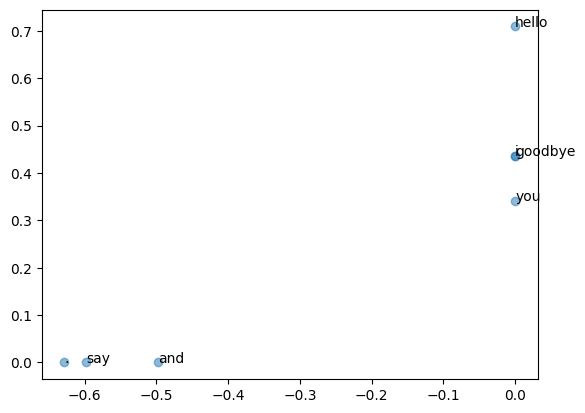

In [51]:
for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
  
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

In [52]:
import os
# ptb 모듈 경로 추가
import sys
sys.path.append('C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝2/dataset')

In [53]:
from ptb import load_data

In [54]:
corpus, word_to_id, id_to_word = load_data('train')

In [55]:
window_size = 2 # 윈도우 크기
wordvec_size = 100 # 단어 임베딩 차원 수
vocab_size = len(word_to_id) # 어휘 수

In [ ]:
C = create_co_matrix(corpus, vocab_size, window_size) # 동시발생 행렬 생성, corpus: 단어 ID 리스트, vocab_size: 어휘 수, window_size: 윈도우 크기
W = ppmi(C, verbose=True) # PPMI 계산

# try:
#   from sklearn.utils.extmath import randomized_svd
#   U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None) # 고속 SVD
  
# except ImportError:
#   U, S, V = np.linalg.svd(W)
  
# word_vecs = U[:, :wordvec_size] # 차원 축소, wordvec_size: 단어 임베딩 차원 수

In [ ]:
most_similar('say', word_to_id, id_to_word, C, top=5) # 코사인 유사도 상위 5개 단어 출력

In [136]:
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.6699886918067932
 we: 0.5964745283126831
 do: 0.5654407143592834
 'd: 0.5091731548309326
 someone: 0.4832755923271179

[query] year
 month: 0.6612287163734436
 quarter: 0.6254000663757324
 earlier: 0.5893720388412476
 june: 0.5827305316925049
 february: 0.5692856907844543

[query] car
 luxury: 0.6450836062431335
 auto: 0.5802451372146606
 truck: 0.5297993421554565
 cars: 0.5115047693252563
 vehicle: 0.5109766721725464

[query] toyota
 motor: 0.7371780872344971
 nissan: 0.658774733543396
 lexus: 0.6483688354492188
 motors: 0.6271815299987793
 honda: 0.6032297611236572
